In [1]:
%reload_ext autoreload
%autoreload 2


import GPUtil
import jax
import jax.numpy as jnp
from utils import *

In [2]:
def set_free_gpu():
    gpus = GPUtil.getGPUs()
    gpu = min(gpus, key=lambda x: x.load)
    device = jax.devices("gpu")[gpu.id]
    jax.config.update("jax_default_device", device)
    print(f"Default device: GPU {gpu.id} ({gpu.name}) load={gpu.load*100}%")


set_free_gpu()

Default device: GPU 0 (NVIDIA L40S) load=0.0%


In [3]:
jax.config.update("jax_default_device", jax.devices("gpu")[1])

# Parameters

In [4]:
params = {
    "Na_2": 20,
    "Nb_2": 5,
    "Nb_1": 50,
    "el": 35.3 * GHz,
    "ej": 18.1 * GHz,
    "phi_a": 0.1,
    "phi_b": 0.234,
    "wa": 1.08 * GHz,
    "wb": 7.9 * GHz,
    "wro": 7.9 * GHz + 0 * MHz,
    "phi_0": 0,
    "kappa_a": 1 / 70 * us,
    "kappa_b": 18 * MHz,
    "tstab": 5 * us,
    "tro": 5 * us,
    "nsave": 501,
    "kappa_2": 0.35 * MHz,
}

# Hamiltonian terms from compensation

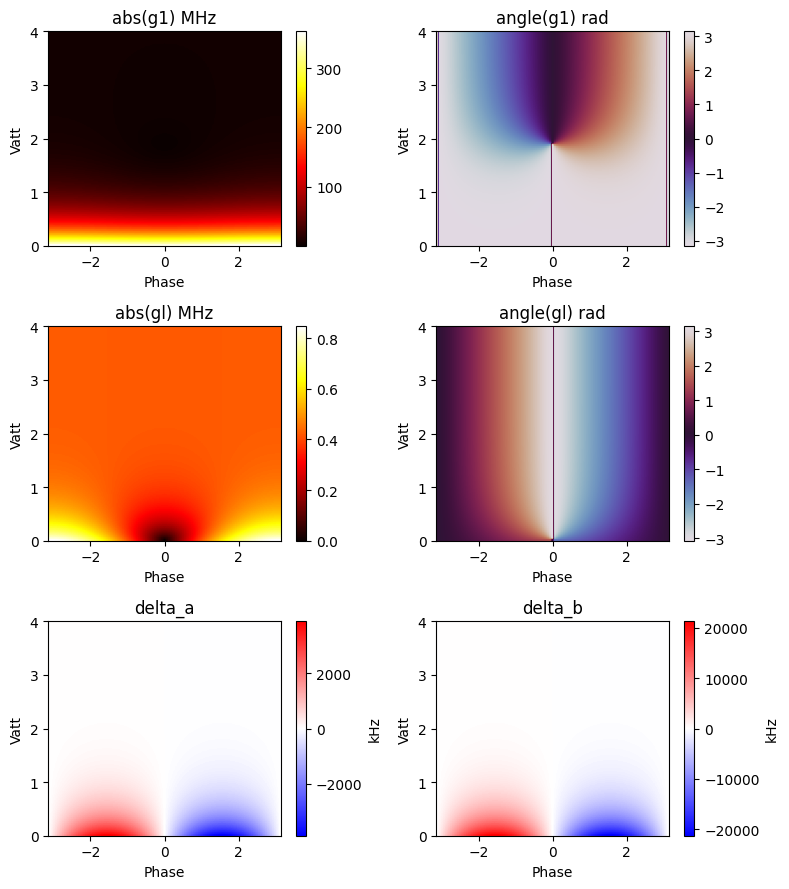

In [5]:
phases = jnp.linspace(-jnp.pi, jnp.pi, 101)
vatts = jnp.linspace(0, 4, 101)
amp = 1e-2

ress = hamiltonian_terms(phases[:, None], vatts[None, :], amp, **params)
ress = ress[:2] + ress[3:]

fig, ax = plt.subplots(3, 2, figsize=(8, 9))
for ind, (subr, name) in enumerate(zip(ress[:2], ["g1", "gl"])):
    for ind2, (f, cmap) in enumerate(zip([jnp.abs, jnp.angle], ["hot", "twilight"])):
        im = ax[ind, ind2].imshow(
            f(subr / MHz).T,
            extent=[phases[0], phases[-1], vatts[0], vatts[-1]],
            aspect="auto",
            cmap=cmap,
            origin="lower",
        )
        fig.colorbar(im, ax=ax[ind, ind2])
        ax[ind, ind2].set_xlabel("Phase")
        ax[ind, ind2].set_ylabel("Vatt")
        ax[ind, ind2].set_title(
            f"{f.__name__}({name})" + (" MHz" if ind2 == 0 else " rad")
        )

for ind, (subr, name) in enumerate(zip(ress[2:], ["delta_a", "delta_b"])):
    extr = jnp.max(jnp.abs(subr / kHz))
    im = ax[2, ind].imshow(
        subr.T / kHz,
        extent=[phases[0], phases[-1], vatts[0], vatts[-1]],
        aspect="auto",
        cmap="bwr",
        origin="lower",
        vmin=-extr,
        vmax=extr,
    )
    fig.colorbar(im, ax=ax[2, ind], label="kHz")
    ax[2, ind].set_xlabel("Phase")
    ax[2, ind].set_ylabel("Vatt")
    ax[2, ind].set_title(name)
fig.tight_layout()

# Def simulate RO

2024-10-03 14:39:32.384654: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 15.98GiB (17155591819 bytes) by rematerialization; only reduced to 33.61GiB (36086203692 bytes), down from 33.61GiB (36086204077 bytes) originally
|██████████| 100.0% ◆ elapsed 26.40s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 33.05s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 33.01s ◆ remaining 0.00ms  


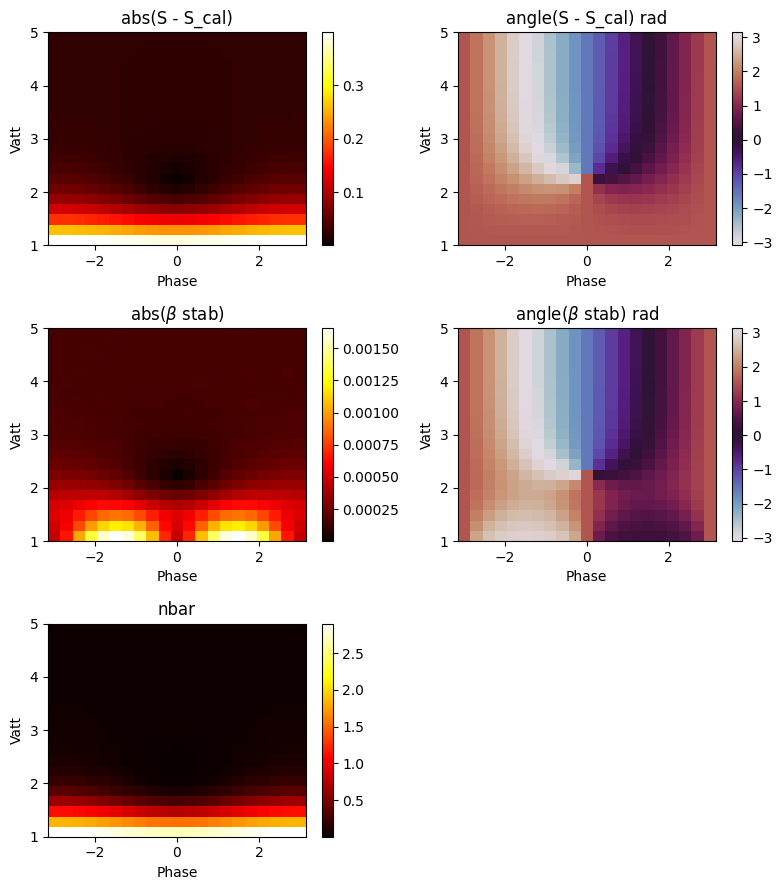

In [7]:
phases = jnp.linspace(-jnp.pi, jnp.pi, 21)
vatts = jnp.linspace(1, 5, 21)
amp_map = 1e-3
amp_ro = 1e-3
phss, vtss = jnp.meshgrid(phases, vatts, indexing="ij")
results = jax.vmap(simulate_sequence, in_axes=(0, 0, None, None, None))(
    phss.flatten(), vtss.flatten(), amp_map, amp_ro, params
)
results = tuple(el.reshape(phss.shape) for el in results)
plot_results(results, phases, vatts)